In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import tensorflow as tf
import numpy as np
import time

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# coding: utf-8

import tensorflow as tf
import numpy as np
import time


class CNN(object):
    """

    """

    def __init__(self, p_keep_conv=1.0, p_keep_hidden=1.0,
                 batch_size=512, test_size=256, epoch_time=3):
        """
        Initialization
        :param batch_size
        :param test_size
        """
        self.w = self._init_weights([3, 3, 1, 32])  # 第一层卷积核大小为3x3,输入一张图,输出32个feature map
        self.w2 = self._init_weights([3, 3, 32, 64])  # 第二层卷积核大小为3x3,输入32个feature map,输出64个feature map
        self.w3 = self._init_weights([3, 3, 64, 148])  # 第三层卷积核大小为3x3,输入64个feature map,输出128个feature map
        self.w4 = self._init_weights([148 * 6 * 6, 1000])
        self.w_o = self._init_weights([1000, 10])  # FC 512 inputs, 10 outputs (labels)
        self.batch_size = batch_size
        self.test_size = test_size
        self.sess = tf.Session()  # tensorflow session
        self.p_keep_conv = p_keep_conv
        self.p_keep_hidden = p_keep_hidden
        self.epoch_time = epoch_time

    def _init_weights(self, shape, name=None):
        """
        初始化参数
        :param shape:
        :param name:
        :return:
        """
        return tf.Variable(tf.random_normal(shape, stddev=0.01), name=name)

    def _cnn(self, X, p_keep_conv, p_keep_hidden):
        """
        :param X:
        :param p_keep_conv:
        :param p_keep_hidden:
        :return:
        """
        # 第一个卷积层:padding=SAME,保证输出的feature map与输入矩阵的大小相同
        l1a = tf.nn.relu(tf.nn.conv2d(X, self.w,  # l1a shape=(?, 48, 48, 32)
                                      strides=[1, 1, 1, 1], padding='SAME'))

        # max_pooling,窗口大小为2x2
        l1 = tf.nn.max_pool(l1a, ksize=[1, 2, 2, 1],  # l1 shape=(?, 24, 24, 32)
                            strides=[1, 2, 2, 1], padding='SAME')
        # dropout:每个神经元有p_keep_conv的概率以1/p_keep_conv的比例进行归一化,有(1-p_keep_conv)的概率置为0
        l1 = tf.nn.dropout(l1, p_keep_conv)

        # 第二个卷积层
        l2a = tf.nn.relu(tf.nn.conv2d(l1, self.w2,  # l2a shape=(?, 24, 24, 64)
                                      strides=[1, 1, 1, 1], padding='SAME'))
        l2 = tf.nn.max_pool(l2a, ksize=[1, 2, 2, 1],  # l2 shape=(?, 12, 12, 64)
                            strides=[1, 2, 2, 1], padding='SAME')
        l2 = tf.nn.dropout(l2, p_keep_conv)

        # 第三个卷积层
        l3a = tf.nn.relu(tf.nn.conv2d(l2, self.w3,  # l3a shape=(?, 12, 12, 128)
                                      strides=[1, 1, 1, 1], padding='SAME'))
        l3 = tf.nn.max_pool(l3a, ksize=[1, 2, 2, 1],  # l3 shape=(?, 6, 6, 128)
                            strides=[1, 2, 2, 1], padding='SAME')
        # 将所有的feature map合并成一个2048维向量
        l4 = tf.reshape(l3, [-1, self.w4.get_shape().as_list()[0]])  # reshape to (?, 2048)
        l4 = tf.nn.dropout(l4, p_keep_conv)
        # 后面两层为全连接层
        l4 = tf.nn.relu(tf.matmul(l4, self.w4))
        l4 = tf.nn.dropout(l4, p_keep_hidden)
        out = tf.matmul(l4, self.w_o)

        return out, l3

    def _cnn_new(self, X, p_keep_conv, p_keep_hidden):
        """
        :param X:
        :param p_keep_conv:
        :param p_keep_hidden:
        :return:
        """
        # 第一个卷积层:padding=SAME,保证输出的feature map与输入矩阵的大小相同
        l1 = tf.nn.relu(tf.nn.conv2d(X, self.w, strides=[1, 1, 1, 1], padding='SAME'))

        # max_pooling,窗口大小为2x2
        l1 = tf.nn.max_pool(l1, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')

        l1 = tf.nn.dropout(l1, p_keep_conv)

        # 第二个卷积层
        l2 = tf.nn.relu(tf.nn.conv2d(l1, self.w2, strides=[1, 1, 1, 1], padding='SAME'))

        l2 = tf.nn.max_pool(l2, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')

        l2 = tf.nn.dropout(l2, p_keep_conv)

        # 第三个卷积层
        l3 = tf.nn.relu(tf.nn.conv2d(l2, self.w3, strides=[1, 1, 1, 1], padding='SAME'))

        l3 = tf.nn.max_pool(l3, ksize=[1, 2, 2, 1],  # l3 shape=(?, 6, 6, 128)
                            strides=[1, 2, 2, 1], padding='SAME')

        # 将所有的feature map合并成一个2048维向量
        l4 = tf.reshape(l3, [-1, self.w4.get_shape().as_list()[0]])  # reshape to (?, 2048)
        l4 = tf.nn.dropout(l4, p_keep_conv)
        # 后面两层为全连接层
        l4 = tf.nn.relu(tf.matmul(l4, self.w4))
        l4 = tf.nn.dropout(l4, p_keep_hidden)
        out = tf.matmul(l4, self.w_o)
        # out = tf.nn.softmax(out)

        return out, l3

    def fit_new(self, train_x, train_y, test_x, test_y):
        """
        :return:
        """
        p_keep_conv = tf.placeholder("float")  # 卷积层的dropout概率
        p_keep_hidden = tf.placeholder("float")  # 全连接层的dropout概率
        X = tf.placeholder("float", [None, 48, 48, 1])
        Y = tf.placeholder("float", [None, 10])

        out, _ = self._cnn_new(X, p_keep_conv, p_keep_hidden)

        cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=out, labels=Y))  # 交叉熵目标函数

        train_op = tf.train.AdamOptimizer(0.001, 0.9) \
            .minimize(cost)  # RMSPro算法最小化目标函数

        predict_op = tf.argmax(out, 1)  # 返回每个样本的预测结果

        init = tf.global_variables_initializer()

        self.sess.run(init)
        for i in range(self.epoch_time):
            training_batch = zip(range(0, len(train_x), self.batch_size),
                                 range(self.batch_size, len(train_x) + 1, self.batch_size))
            tm = time.time()
            for start, end in training_batch:
                # print(train_x[start:end].shape, train_y[start:end].shape)
                self.sess.run(
                    train_op,
                    feed_dict={X: train_x[start:end],
                               Y: train_y[start:end],
                               p_keep_conv: self.p_keep_conv,
                               p_keep_hidden: self.p_keep_hidden})

            test_indices = np.arange(len(test_x))
            np.random.shuffle(test_indices)
            test_indices = test_indices[0: self.test_size]

            acc = np.mean(np.argmax(test_y[test_indices], axis=1) ==
                                          self.sess.run(
                                              predict_op, feed_dict={
                                                  X: test_x[test_indices],
                                                  p_keep_conv: 1.0,
                                                  p_keep_hidden: 1.0}))

            print('epoch %s' % (i + 1), 'accuracy %s' % acc, '\t time cost %s' % (time.time() - tm))
            # if acc >= 1.0: break  # 提前终止

    def save(self, model_name):
        """

        :param model_name:
        :return:
        """
        saver = tf.train.Saver()
        saver.save(self.sess, model_name)
        print("save model:{0} Finished".format(model_name))

    def predict(self, img):
        """

        :param img:
        :return:
        """
        p_keep_conv = tf.placeholder("float")  # 卷积层的dropout概率
        p_keep_hidden = tf.placeholder("float")  # 全连接层的dropout概率
        X = tf.placeholder("float", [None, 48, 48, 1])

        out = self._cnn_main(X, p_keep_conv, p_keep_hidden)
        predict_op = tf.argmax(out, 1)  # 返回每个样本的预测结果

        predict = self.sess.run(
            predict_op, feed_dict={
                X: img.reshape(-1, 48, 48, 1),
                p_keep_conv: 1.0,
                p_keep_hidden: 1.0})

        return predict

    def predict_new(self, img):
        """

        :param img:
        :return:
        """
        p_keep_conv = tf.placeholder("float")  # 卷积层的dropout概率
        p_keep_hidden = tf.placeholder("float")  # 全连接层的dropout概率
        X = tf.placeholder("float", [None, 48, 48, 1])
        out, pool = self._cnn(X, p_keep_conv, p_keep_hidden)
        predict_op = tf.argmax(out, 1)  # 返回每个样本的预测结果
        predict = self.sess.run(
            predict_op, feed_dict={
                X: img.reshape(-1, 48, 48, 1),
                p_keep_conv: 1.0,
                p_keep_hidden: 1.0})
        return predict

    def output(self, img):
        """

        :param img:
        :return:
        """
        p_keep_conv = tf.placeholder("float")  # 卷积层的dropout概率
        p_keep_hidden = tf.placeholder("float")  # 全连接层的dropout概率
        X = tf.placeholder("float", [None, 48, 48, 1])
        out, pool = self._cnn(X, p_keep_conv, p_keep_hidden)
        output = self.sess.run(
            pool, feed_dict={
                X: img.reshape(-1, 48, 48, 1),
                p_keep_conv: 1.0,
                p_keep_hidden: 1.0})
        probs = self.sess.run(
            out, feed_dict={
                X: img.reshape(-1, 48, 48, 1),
                p_keep_conv: 1.0,
                p_keep_hidden: 1.0})
        return output, probs

    def load_session(self, model_name):
        """

        :param model_name:
        :return:
        """
        # init = tf.global_variables_initializer()
        # self.sess.run(init)
        saver = tf.train.Saver()
        saver.restore(self.sess, model_name)


In [3]:
cnn = CNN()

In [4]:
# cnn.load_session('../model/New_CNN_Model.ckpt')
cnn.load_session('../model_new/New_CNN_Model.ckpt')

INFO:tensorflow:Restoring parameters from ../model_new/New_CNN_Model.ckpt


In [5]:
tf.all_variables()

Instructions for updating:
Please use tf.global_variables instead.


[<tf.Variable 'Variable:0' shape=(3, 3, 1, 32) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(3, 3, 32, 64) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(3, 3, 64, 148) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(5328, 1000) dtype=float32_ref>,
 <tf.Variable 'Variable_4:0' shape=(1000, 10) dtype=float32_ref>]

In [6]:
def get_non0_index_scope(l):
    """

    :param l:
    :return:
    """
    if l[0]:
        start = 0
    else:
        start = l.index(True)
    l.reverse()
    if l[0]:
        end = 0
    else:
        end = l.index(True)
    end = len(l) - end
    return start, end


def get_min_content_area(img):
    """

    :param img:
    :return:
    """
    col_proj = (np.sum(img, axis=0) != 0).tolist()
    row_proj = (np.sum(img, axis=1) != 0).tolist()
    col_start, col_end = get_non0_index_scope(col_proj)
    row_start, row_end = get_non0_index_scope(row_proj)

    return row_start, row_end, col_start, col_end


def get_resize_padding_img(img, size=None, padding=None):
    """

    :param img:
    :param size:
    :param padding:
    :return:
    """
    if size and padding:
        sub_img = cv2.resize(img, size)
        sub_img = np.pad(sub_img, padding, mode='constant')
        sub_img = np.pad(sub_img, ((3,), (3,)), mode='constant')
    else:
        sub_img = cv2.resize(img, (28, 28))
    return sub_img

In [7]:
def preprocessing(img):
    row_start, row_end, col_start, col_end = get_min_content_area(img)
    sub_img = img[row_start: row_end, col_start: col_end]
    
    if col_end - col_start < row_end - row_start:  # 铅直边较长
#         print(col_end - col_start, row_end - row_start)
        change_rate = (row_end - row_start - 42) / float((row_end - row_start))
        changed_width = int((col_end - col_start) * (1 - change_rate))

        if changed_width % 2 == 1:
            changed_width += 1
        if changed_width == 0:
            changed_width = 2
        pad = (42 - changed_width) / 2
        padding = ((0,), (int(pad),))

#         print(y1 - y0, x1 - x0, 1 - change_rate, changed_width, pad)
#         plt.imshow(sub_img)
#         plt.show()

        sub_img = get_resize_padding_img(sub_img, size=(changed_width, 42), padding=padding)

    else:  # 水平边较长
        # change_rate = (x1 - x0 - 42) / float((x1 - x0))
        # changed_height = int((y1 - y0) * (1 - change_rate))

        change_rate = (col_end - col_start - 42) / float((col_end - col_start))
        changed_height = int((row_end - row_start) * (1 - change_rate))

        if changed_height % 2 == 1:
            changed_height += 1
        if changed_height == 0:
            changed_height = 2
        pad = (42 - changed_height) / 2
        padding = ((int(pad),), (0,))

#         print(y1 - y0, x1 - x0, 1 - change_rate, changed_height, pad)
#         plt.imshow(sub_img)
#         plt.show()

        sub_img = get_resize_padding_img(sub_img, size=(42, changed_height), padding=padding)

    return sub_img

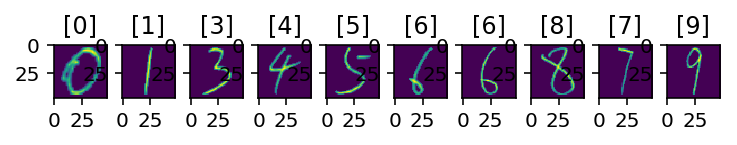

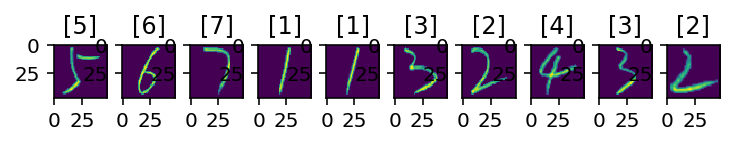

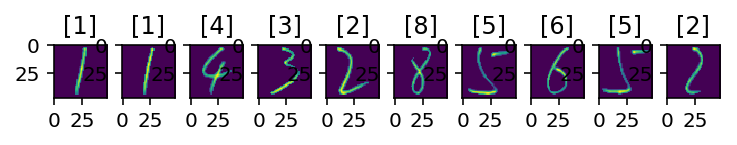

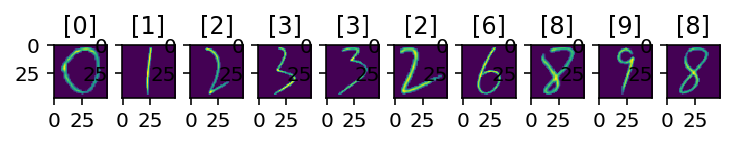

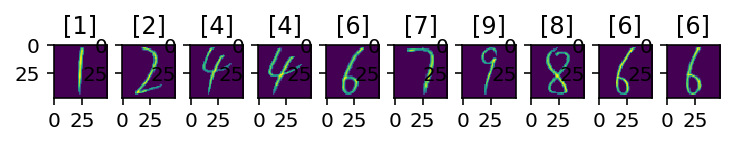

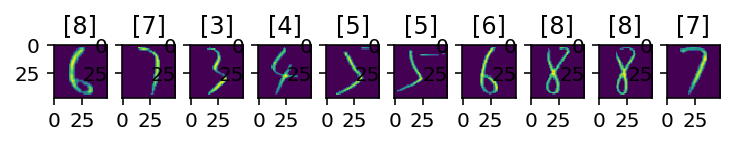

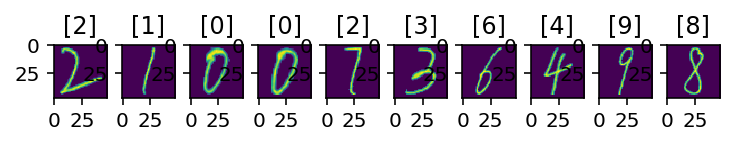

In [8]:
for j in range(0, 7):
    
    for i in range(1, 11):
        img = cv2.imread('testimg/%s/%s.jpg' % (j, i), cv2.IMREAD_GRAYSCALE)
        img = (255 - img) / 255.0
        img[img < 0.14] = 0.0
        img = (img - np.min(img)) / (np.max(img) - np.min(img))

        sub_img = preprocessing(img)

#             cv2.imwrite(fname, sub_img * 255)
        plt.subplot(7, 10, i + j * 10)
        plt.imshow(sub_img)
        plt.title(cnn.predict_new(sub_img))
    plt.show()

In [9]:
o, probs = cnn.output(sub_img)
o.shape

(1, 6, 6, 148)

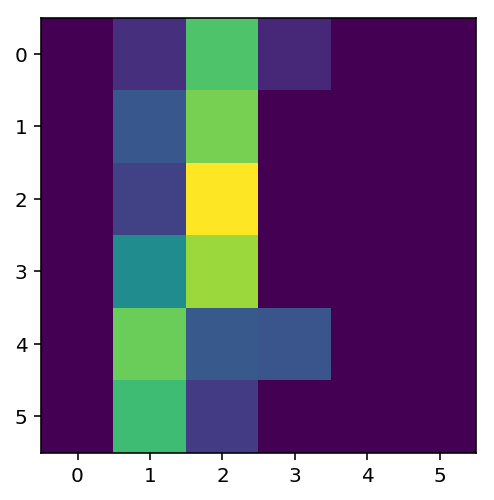

In [10]:
plt.imshow(o[0, :, :, 101])

In [11]:
probs[0]

array([  -61.16786 , -1224.2234  ,   732.1485  ,   -38.029877,
       -1629.6471  ,  -848.61774 ,  -738.2736  , -1750.0397  ,
        2124.6292  ,  -708.55304 ], dtype=float32)

---

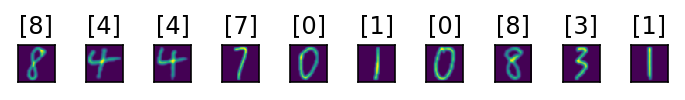

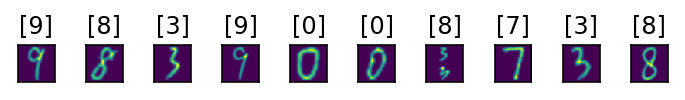

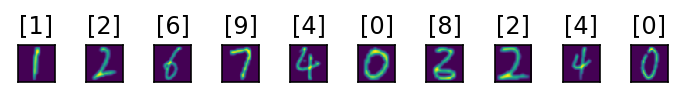

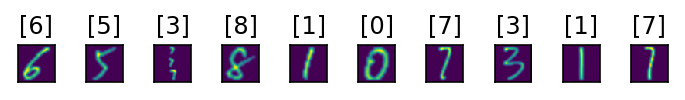

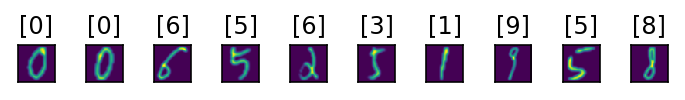

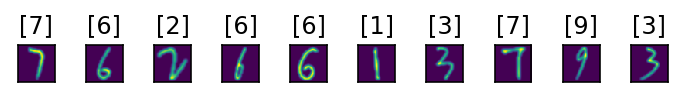

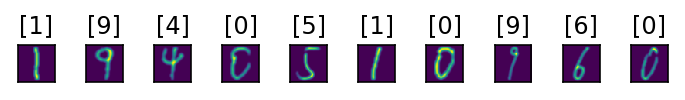

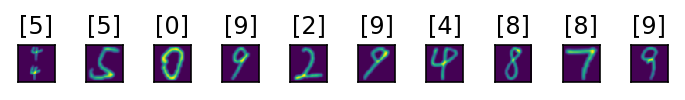

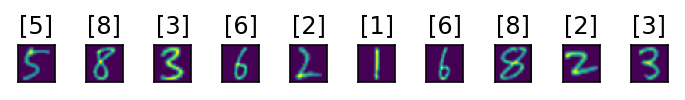

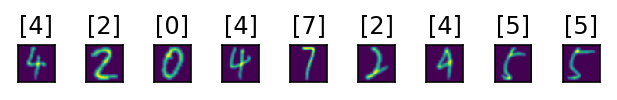

In [21]:
import os
j = 1
for i in os.listdir('F:\\nums'):
    
    img = cv2.imread(os.path.join('F:\\nums', i), cv2.IMREAD_GRAYSCALE)

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img[img > 1.0] = 1.0
    img[img < 0.16] = 0.0

    sub_img = preprocessing(img)
    
    plt.subplot(10, 10, j)
    plt.imshow(sub_img)
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.axis = False
    plt.title(cnn.predict_new(np.expand_dims(sub_img, axis=-1)))
    
    if j % 10 == 0:
        plt.show()
    j += 1

---

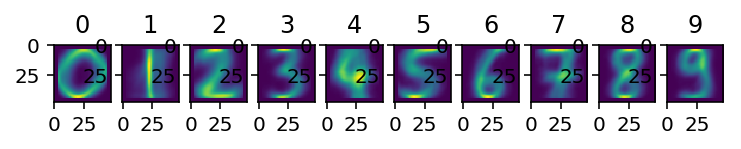

In [32]:
import os
pt = 'F:\\num_ocr'
dic = {}
for i in range(10):
    y = i
    X = []
    for j in os.listdir(os.path.join(pt, str(i))):
        x = cv2.imread(os.path.join(pt, str(i), str(j)), cv2.IMREAD_GRAYSCALE)
        X.append(x.tolist())
#     print(np.array(X).shape)
    mu = np.mean(np.array(X), axis=0)
#     print(i, mu.shape, mu)
    dic[y] = mu
    
for i, j in dic.items():
    plt.subplot(1, 10, i + 1)
    plt.title(i)
    plt.imshow(j)

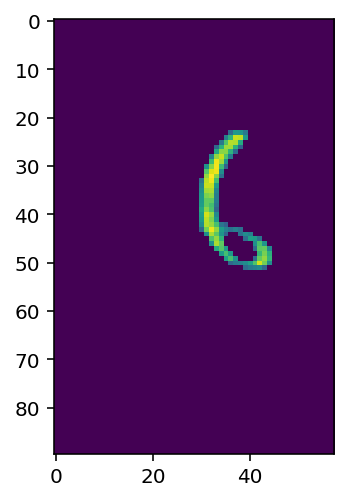

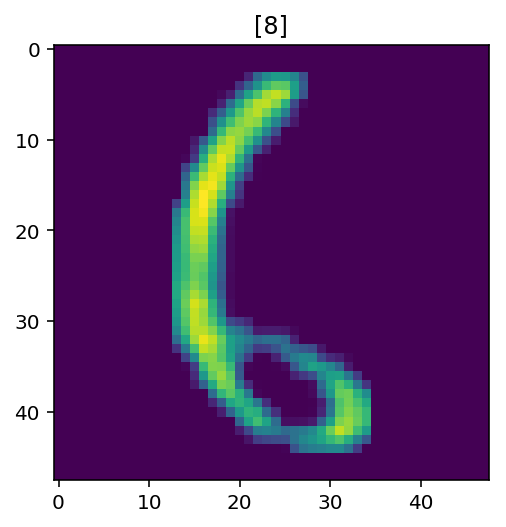

In [14]:
img = cv2.imread('testimg/%s/%s.jpg' % (5, 1), cv2.IMREAD_GRAYSCALE)
img = (255 - img) / 255.0

img[img < 0.14] = 0.0
img = (img - np.min(img)) / (np.max(img) - np.min(img))
plt.imshow(img)
plt.show()

sub_img = preprocessing(img)
plt.title(cnn.predict_new(np.expand_dims(sub_img, axis=-1)))
plt.imshow(sub_img)

In [15]:
for i, j in dic.items():
    print(i, np.mean(np.abs(sub_img - j) / np.mean(j)))

0 0.9978942498150306
1 0.9957144077771252
2 0.9973949087160476
3 0.9972437871863709
4 0.9971090696253131
5 0.9974122606314503
6 0.9972960707598069
7 0.9971083499049259
8 0.9979090414963334
9 0.9975458420039859


In [16]:
for i, j in dic.items():
#     print(i, np.mean(np.abs(sub_img - j) / np.mean(j)))
    print(i, np.mean(np.cov(j, sub_img)))

0 77.60862878571011
1 139.7165876850648
2 120.25746355162634
3 188.5326307348362
4 133.28362807535436
5 124.31479786162751
6 221.27838681521428
7 151.14470182528396
8 343.9141215638565
9 245.81414069933442


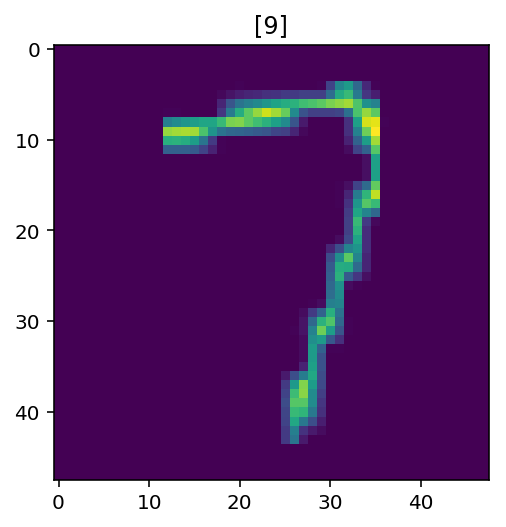

In [39]:
img = cv2.imread(os.path.join('F:\\nums', '3476.jpg'), cv2.IMREAD_GRAYSCALE)
element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
img = cv2.erode(img, element, iterations=1)
plt.title(cnn.predict_new(np.expand_dims(img, axis=-1)))
plt.imshow(img)

In [28]:
_, probs = cnn.output(np.expand_dims(img, axis=-1))
probs

array([[ -91360.01 ,   69386.195,  -76009.77 ,  -99673.08 , -361758.97 ,
        -330168.7  , -570726.5  ,   45224.906, -100542.62 ,  153764.92 ]],
      dtype=float32)

In [25]:
for i, j in dic.items():
    print(i, np.mean(np.abs(img - j) / np.mean(j)))

0 0.8526581676131886
1 1.0089194017216054
2 0.949789888594805
3 0.8954998262169194
4 0.8694784859735424
5 0.8701999112312357
6 0.9502703348080789
7 0.823224197479985
8 0.8300704122487547
9 0.8111164803946587


In [48]:
for i, j in dic.items():
#     print(i, np.mean(np.abs(sub_img - j) / np.mean(j)))
    print(i, np.mean(np.cov(j / np.mean(j), img)))

0 7.57898387515309
1 8.990523537555951
2 8.07734696296768
3 9.204928338858126
4 8.679132217387014
5 8.152458341253821
6 8.590190846300281
7 9.068534266369719
8 8.836631099800957
9 9.35394524679791


In [40]:
np.cov(j, img).shape

(96, 96)

In [41]:
j.shape, img.shape

((48, 48), (48, 48))

In [75]:
a = np.random.randn(2, 10)
b = np.random.randn(2, 10)

In [76]:
np.cov(a, b)

array([[ 0.38923255, -0.06224506,  0.35719753, -0.03247764],
       [-0.06224506,  1.80634939, -0.42952677,  0.29566586],
       [ 0.35719753, -0.42952677,  0.75362811, -0.04943906],
       [-0.03247764,  0.29566586, -0.04943906,  0.76328849]])

In [114]:
c = np.linspace(-3, 3, 100)

In [115]:
np.random.nor

array([-3.        , -2.93939394, -2.87878788, -2.81818182, -2.75757576,
       -2.6969697 , -2.63636364, -2.57575758, -2.51515152, -2.45454545,
       -2.39393939, -2.33333333, -2.27272727, -2.21212121, -2.15151515,
       -2.09090909, -2.03030303, -1.96969697, -1.90909091, -1.84848485,
       -1.78787879, -1.72727273, -1.66666667, -1.60606061, -1.54545455,
       -1.48484848, -1.42424242, -1.36363636, -1.3030303 , -1.24242424,
       -1.18181818, -1.12121212, -1.06060606, -1.        , -0.93939394,
       -0.87878788, -0.81818182, -0.75757576, -0.6969697 , -0.63636364,
       -0.57575758, -0.51515152, -0.45454545, -0.39393939, -0.33333333,
       -0.27272727, -0.21212121, -0.15151515, -0.09090909, -0.03030303,
        0.03030303,  0.09090909,  0.15151515,  0.21212121,  0.27272727,
        0.33333333,  0.39393939,  0.45454545,  0.51515152,  0.57575758,
        0.63636364,  0.6969697 ,  0.75757576,  0.81818182,  0.87878788,
        0.93939394,  1.        ,  1.06060606,  1.12121212,  1.18